In [ ]:
!wget https://github.com/xingchenzhao/deep-learning-team-project/raw/master/dataset.py
!wget https://github.com/xingchenzhao/deep-learning-team-project/raw/master/setup.py
!wget https://github.com/xingchenzhao/deep-learning-team-project/raw/master/utils.pyx
!wget https://github.com/xingchenzhao/deep-learning-team-project/raw/master/visualization.py
!wget https://github.com/xingchenzhao/deep-learning-team-project/raw/master/generation.py
!wget https://transfer.sh/1U5VuHG/mutual_skeleton_medium.zip

--2021-07-19 20:33:37--  https://github.com/xingchenzhao/deep-learning-team-project/raw/master/dataset.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/xingchenzhao/Generating-Human-Skeletons-with-Mutual-Actions-WGAN-Pytorch/raw/master/dataset.py [following]
--2021-07-19 20:33:37--  https://github.com/xingchenzhao/Generating-Human-Skeletons-with-Mutual-Actions-WGAN-Pytorch/raw/master/dataset.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xingchenzhao/Generating-Human-Skeletons-with-Mutual-Actions-WGAN-Pytorch/master/dataset.py [following]
--2021-07-19 20:33:37--  https://raw.githubusercontent.com/xingchenzhao/Generating-Human-Skeletons-with-Mutual-Actions-WGAN-Pytorch/master/dataset.py
Resolving raw.githubusercontent.com (raw.gi

In [ ]:
!unzip mutual_skeleton_medium.zip

Streaming output truncated to the last 5000 lines.
  inflating: processed_mutual_data_medium/S003C002P002R001A051.skeleton  
  inflating: processed_mutual_data_medium/S002C001P014R001A060.skeleton  
  inflating: processed_mutual_data_medium/S011C002P001R002A052.skeleton  
  inflating: processed_mutual_data_medium/S016C002P040R001A060.skeleton  
  inflating: processed_mutual_data_medium/S007C003P018R002A058.skeleton  
  inflating: processed_mutual_data_medium/S007C001P027R001A050.skeleton  
  inflating: processed_mutual_data_medium/S002C001P008R002A059.skeleton  
  inflating: processed_mutual_data_medium/S013C002P016R002A051.skeleton  
  inflating: processed_mutual_data_medium/S012C001P027R001A060.skeleton  
  inflating: processed_mutual_data_medium/S003C001P016R001A060.skeleton  
  inflating: processed_mutual_data_medium/S013C001P016R002A052.skeleton  
  inflating: processed_mutual_data_medium/S013C001P008R002A058.skeleton  
  inflating: processed_mutual_data_medium/S002C003P003R001A06

In [ ]:
!pip install cython -U
!python setup.py build_ext --inplace

     |████████████████████████████████| 2.0 MB 36.2 MB/s 
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:
      Successfully uninstalled Cython-0.29.23
Compiling utils.pyx because it changed.
[1/1] Cythonizing utils.pyx
running build_ext
building 'utils' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-LSlbJj/python3.7-3.7.11=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-LSlbJj/python3.7-3.7.11=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/python3.7m -c utils.c -o build/temp.linux-x86_64-3.7/utils.o
In file included from /usr/local/lib/python3.7/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1822

In [ ]:
#The scripts above are for downloading necessary datasets and dependency code. 
#The mutual dataset is a "mutual action" subset of the NTUSkeleton dataset. I
#I get this split of dataset through the "get_mutual_actions.sh" in my github repo.
# Basically, "get_mutual_actions.sh" just copy the mutual action skeleton according to the dataset website.
#You don't need to run "get_mutual_actions.sh" here, since I already done this.
#Also, please download "https://transfer.sh/1U5VuHG/mutual_skeleton_medium.zip" to your local drive or google drive, because this link will be invalid in a few days.

In [ ]:
#The main code I am using is "wgan_2p_filter_2_save_model.py" 
#The naming is bad. It basically means Wasserstein GAN.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from dataset import NTUSkeletonDataset
from torch.utils.data import Dataset, DataLoader
# import gan
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import visualization as vs
from pathlib import Path


In [ ]:
# Root directory for dataset
dataroot = "processed_mutual_data_medium"

# Batch size during training
batch_size = 5

# Size of z latent vector (i.e. size of generator input)
latent_dim = 50

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.00005

clip_value = 0.01
n_critic = 5


In [ ]:
trainset = NTUSkeletonDataset(root_dir=dataroot, pinpoint=21, pin_body=1)
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=4)
ngpu = 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
KEYPOINTS = 25
DIM = 2  # x and y
PERSON = 2
FRAME = 30
img_shape = (PERSON, KEYPOINTS, DIM)
warm_start = False
model_save_epoch = 15

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            # layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.ReLU())

            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=True),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, PERSON*KEYPOINTS*DIM),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.reshape(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [ ]:
generator = Generator()
discriminator = Discriminator()
cuda = True if torch.cuda.is_available() else False
# cuda = False
if cuda:
    generator.cuda('cuda:0')
    discriminator.cuda('cuda:0')
    device = torch.device("cuda:0" if (
        torch.cuda.is_available() and ngpu > 0) else "cpu")
else:
    device = torch.device('cpu')


optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
# optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
batches_done = 0

In [ ]:
#get valid data
def valid_data(data):
    result = np.array([]).reshape((0, 2, 25, 2))
    ori_data = data
    invalid_counter = 0
    for i in range(data.shape[0]):
        count_x_0 = 0
        count_y_0 = 0
        count_x_1 = 0
        count_y_1 = 0

        for p in range(data.shape[2]):
            if(data[i, 0, p, 0] >= 0.2):
                count_x_0 += 1
            if(data[i, 0, p, 1] != 0):
                count_y_0 += 1
            if(data[i, 1, p, 0] >= 0.2):
                count_x_1 += 1
            if(data[i, 1, p, 1] != 0):
                count_y_1 += 1
        if((count_x_0 >= 5 and count_y_0 >= 20) and (count_x_1 >= 5 and count_y_1 >= 20)):
            good_data = data[i, :, :, :]
            good_data = np.expand_dims(good_data, axis=0)

            result = np.concatenate((result, good_data))
        else:
            invalid_counter += 1
    while(result.shape[0] != ori_data.shape[0]):
        rand_num = np.random.randint(low=0, high=result.shape[0])
        add_batch = result[rand_num, :, :, :]
        add_batch = np.expand_dims(add_batch, axis=0)
        result = np.concatenate((result, add_batch))
    return result

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/100] [Batch 0/1138] [D loss: 0.007498] [G loss: 0.009650] [invalid_batch: 0]
[Epoch 0/100] [Batch 5/1138] [D loss: -0.000006] [G loss: 0.009652] [invalid_batch: 0]
[Epoch 0/100] [Batch 10/1138] [D loss: -0.000013] [G loss: 0.009653] [invalid_batch: 0]
[Epoch 0/100] [Batch 19/1138] [D loss: -0.000029] [G loss: 0.009656] [invalid_batch: 1]
[Epoch 0/100] [Batch 24/1138] [D loss: -0.000031] [G loss: 0.009656] [invalid_batch: 1]
[Epoch 0/100] [Batch 27/1138] [D loss: -0.000054] [G loss: 0.009656] [invalid_batch: 3]
[Epoch 0/100] [Batch 31/1138] [D loss: -0.000087] [G loss: 0.009655] [invalid_batch: 4]
[Epoch 0/100] [Batch 34/1138] [D loss: -0.000089] [G loss: 0.009654] [invalid_batch: 6]
[Epoch 0/100] [Batch 42/1138] [D loss: -0.000146] [G loss: 0.009651] [invalid_batch: 8]
[Epoch 0/100] [Batch 46/1138] [D loss: -0.000248] [G loss: 0.009656] [invalid_batch: 9]
[Epoch 0/100] [Batch 51/1138] [D loss: -0.000240] [G loss: 0.009661] [invalid_batch: 9]
[Epoch 0/100] [Batch 60/1138] [D lo

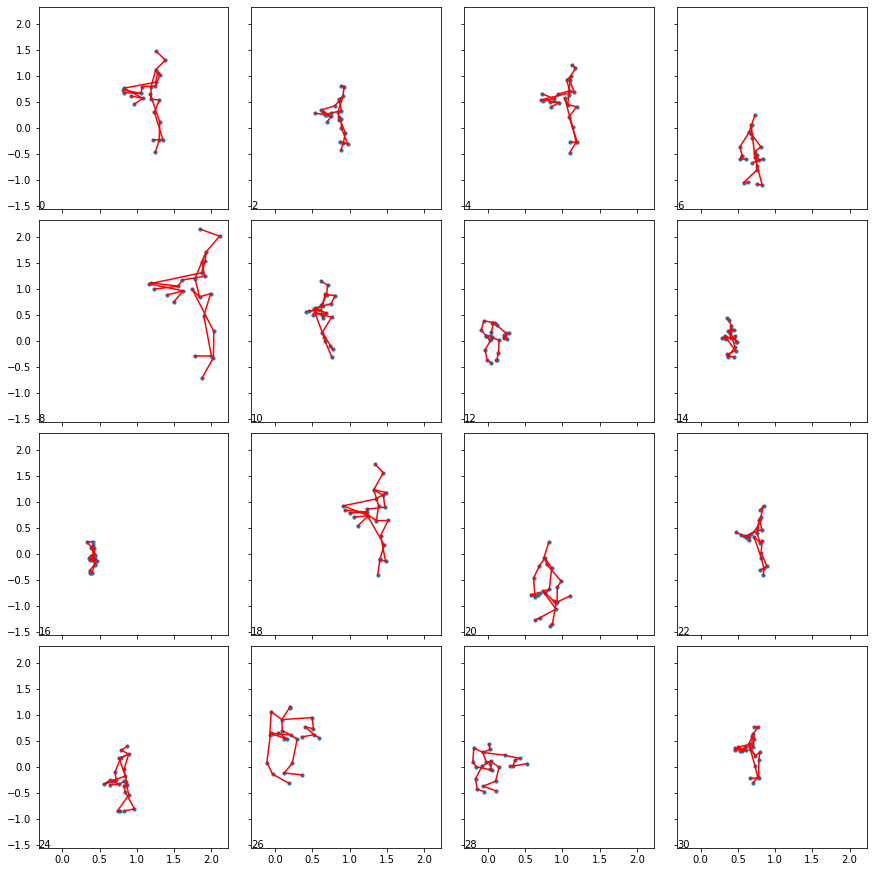

display second skeleton:


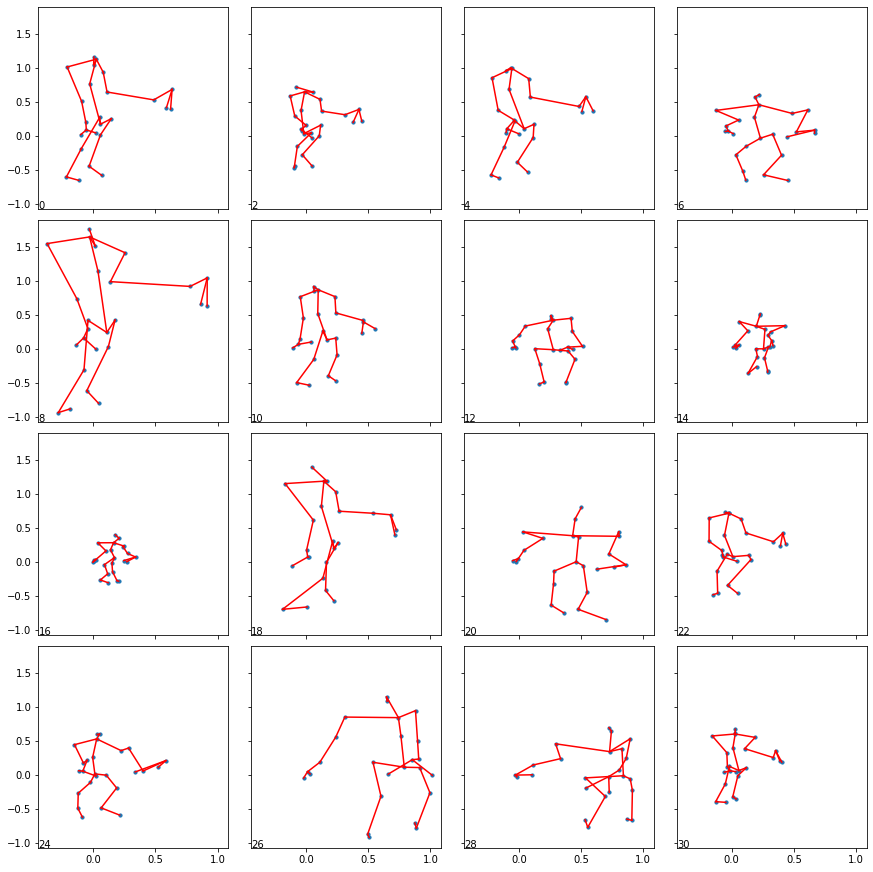

display both two skeletons and their mutual actions:


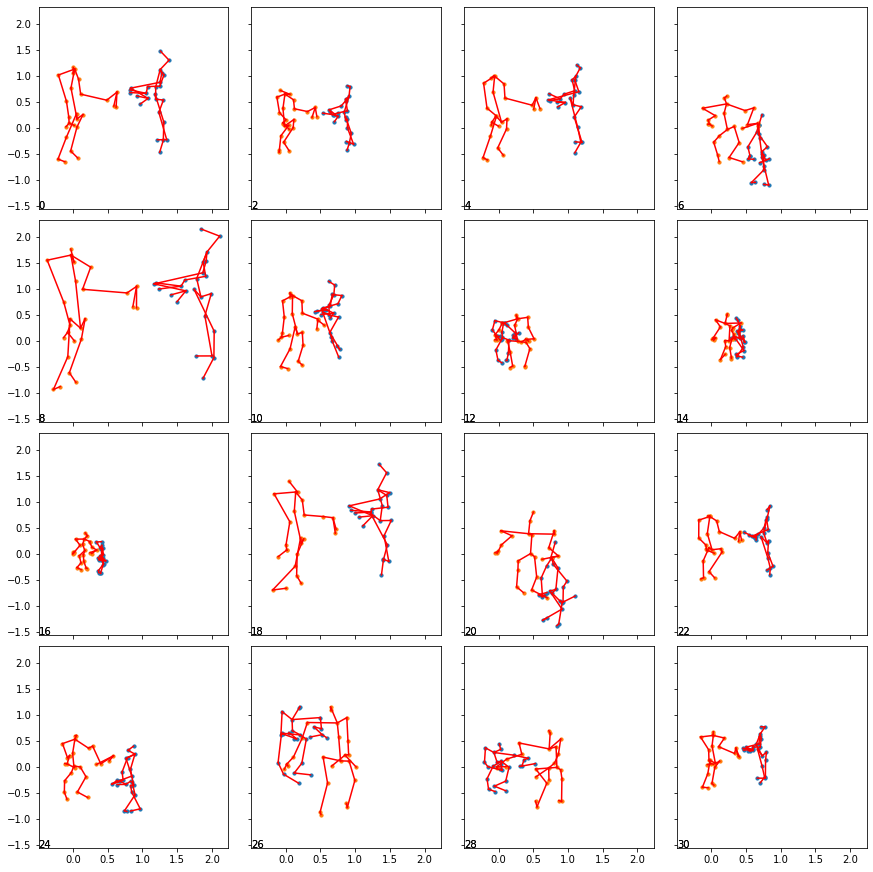

[Epoch 2/100] [Batch 0/1138] [D loss: -0.000689] [G loss: 0.004880] [invalid_batch: 450]
[Epoch 2/100] [Batch 4/1138] [D loss: 0.002637] [G loss: 0.005661] [invalid_batch: 451]
[Epoch 2/100] [Batch 8/1138] [D loss: -0.003711] [G loss: 0.011154] [invalid_batch: 452]
[Epoch 2/100] [Batch 11/1138] [D loss: -0.001604] [G loss: 0.012853] [invalid_batch: 454]
[Epoch 2/100] [Batch 20/1138] [D loss: -0.002292] [G loss: 0.019693] [invalid_batch: 455]
[Epoch 2/100] [Batch 25/1138] [D loss: -0.004015] [G loss: 0.021540] [invalid_batch: 455]
[Epoch 2/100] [Batch 29/1138] [D loss: -0.004202] [G loss: 0.017820] [invalid_batch: 456]
[Epoch 2/100] [Batch 33/1138] [D loss: -0.009209] [G loss: 0.020942] [invalid_batch: 457]
[Epoch 2/100] [Batch 38/1138] [D loss: -0.004211] [G loss: 0.012821] [invalid_batch: 457]
[Epoch 2/100] [Batch 43/1138] [D loss: -0.009958] [G loss: 0.014547] [invalid_batch: 457]
[Epoch 2/100] [Batch 46/1138] [D loss: -0.005343] [G loss: 0.008791] [invalid_batch: 459]
[Epoch 2/100] 

In [ ]:
total_invalid_frame = 0
#invalid data here means the data that bad training skeletons. "valid_data" method will filter out the bad data.
for epoch in range(num_epochs):
    epoch_start = time.time()
    valid_error = False
    for i, data in enumerate(trainloader):
        valid_error = False
        frame = data.shape[3]
        PERSON = data.shape[1]
        # f_num = np.random.randint(low=0, high=100)
        # f_num = np.random.randint(low=30, high=100)
        data = data.transpose(1, 2)
        s_num = (np.random.randint(low=0, high=3))*30
        data = data[:, s_num:s_num+30, :, :]
        data = data.reshape((data.shape[0]*data.shape[1]),
                            data.shape[2], data.shape[3], data.shape[4])
        p_num = 0

        try:
            input_x = valid_data(data)
        except:
            valid_error = True
            total_invalid_frame += 1
            continue
        input_x = torch.from_numpy(input_x)
        real_skeleton = Variable(input_x.type(Tensor)).to(device)

        optimizer_D.zero_grad()
        z = Variable(Tensor(np.random.normal(
            0, 1, (data.shape[0], latent_dim)))).to(device)

        # Generate a batch of skeleton
        fake_skeleton = generator(z).detach()

        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_skeleton)) + \
            torch.mean(discriminator(fake_skeleton))

        loss_D.backward()
        optimizer_D.step()

        # clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_skeleton = generator(z)

            # Adversial loss
            loss_G = -torch.mean(discriminator(gen_skeleton))

            loss_G.backward()
            optimizer_G.step()

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [invalid_batch: %d]"
                  % (epoch, num_epochs, batches_done % len(trainloader), len(trainloader), loss_D.item(), loss_G.item(), total_invalid_frame)
                  )
        batches_done += 1
    epoch_end = time.time()
    print("time eplased: ", epoch_end-epoch_start)
    batches_done = 0
    # model_saving_dir = 'simple_wgan_exp/model_checkpoint/cp_epoch_%d_.tar' % (
    #   epoch)
    # if (epoch % model_save_epoch == 0):
    #     torch.save({
    #         'generator_state_dict': generator.state_dict(),
    #         'discriminator_state_dict': discriminator.state_dict(),
    #         'optimizer_G_state_dict': optimizer_G.state_dict(),
    #         'optimizer_D_state_dict': optimizer_D.state_dict(),
    #         'epoch': epoch,
    #         'loss_D': loss_D.item(),
    #         'loss_G': loss_G.item(),
    #         'total_invalid_frame': total_invalid_frame
    #     }, model_saving_dir)
    if not valid_error:
        gen_skeleton_np = gen_skeleton.transpose(0, 1)
        gen_skeleton_np = gen_skeleton_np.cpu().detach().numpy()
        # gen_skeleton_np = np.expand_dims(gen_skeleton_np, axis=0)
        firstSkeleton = gen_skeleton_np[0:1, :, :, 0:2]
        secondSkeleton = gen_skeleton_np[1:2, :, :, 0:2]

        fig, ax = vs.draw_skeleton(firstSkeleton, step=2)
        Path('simple_wgan_exp/fig/fig_2p_0').mkdir(parents=True, exist_ok=True)
        Path('simple_wgan_exp/fig/fig_2p_1').mkdir(parents=True, exist_ok=True)
        Path('simple_wgan_exp/fig/fig_2p_2').mkdir(parents=True, exist_ok=True)
        plt.savefig('simple_wgan_exp/fig/fig_2p_0/epoch%d_%3f_%3f_p%d.jpg' %
                    (epoch, loss_D.item(), loss_G.item(), 0))
        print("display first skeleton:")
        plt.show()
        fig, ax = vs.draw_skeleton(secondSkeleton, step=2)
        plt.savefig('simple_wgan_exp/fig/fig_2p_1/epoch%d_%3f_%3f_p%d.jpg' %
                    (epoch, loss_D.item(), loss_G.item(), 1))
        print("display second skeleton:")
        plt.show()
        fig, ax = vs.draw_skeleton(
            gen_skeleton_np[:, :, :, 0:2], step=2, max_bodies=2)
        plt.savefig('simple_wgan_exp/fig/fig_2p_2/epoch%d_%3f_%3f_p%d.jpg' %
                    (epoch, loss_D.item(), loss_G.item(), 2))
        print("display both two skeletons and their mutual actions:")
        plt.show()
    else:
        valid_error = False
        print("cannot display since the data of current batch is invalid.")
print("total invalid frame: ", total_invalid_frame)